# <font color='green'>Recommender Systems - A Comprehensive Overview


A recommender system, or a recommendation system, is a subclass of information filtering system that provides suggestions for items that are most pertinent to a user. Typically, the suggestions refer to various decision-making processes, such as what movie to watch, product to purchase, what music to listen to, or what online news to read. Recommender systems are particularly useful when an individual needs to choose an item from a potentially overwhelming number of items that a service may offer.

Recommender systems are used in a variety of areas, with commonly recognised examples taking the form of playlist generators for video and music services, product recommenders for online stores, or content recommenders for social media platforms and open web content recommenders. There are also popular recommender systems for specific topics like restaurants and online dating.

Recommender systems function with two kinds of information:

-  Characteristic information - This is information about items (keywords, categories, etc.) and users (preferences, profiles, etc.).
-  User-item interactions - This is information such as ratings, number of purchases, likes, etc


Based on this, we can distinguish between three algorithms used in recommender systems:

-  Content-based systems, which use characteristic information
-  Collaborative filtering systems, which are based on user-item interactions
-  Hybrid systems, which combine both types of information with the aim of avoiding problems that are generated when working with just one kind

In this notebook, we will be implementing Content-based and Collaborative Filtering systems to recommend movies by using Movies Metadata collected from TMDB (https://www.themoviedb.org/) which consists of 26,000,000 ratings and 750,000 tag applications applied to 46,000 movies by 270,000 users. The data used in the notebook can be found here (https://www.kaggle.com/code/rounakbanik/movie-recommender-systems/data)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
import operator

from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from sentence_transformers import SentenceTransformer

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

%matplotlib inline
import warnings; warnings.simplefilter('ignore')

In [16]:
md = pd.read_csv('C:/Users/balaj/Downloads/archive/movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


## <font color='green'>Section 1 - Exploratory Data Analysis (EDA)

Before going into the nuts and bolts of the Recommender systems, let's first take a look at the data and perform some Exploratory Data Analysis. This would help us to truly understand what the data contains and help us create a better model.

In [3]:
md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

We can see that the data contains 45,466 rows and 24 columns where each record contains information about a particular movie.
Only 4 columns have numerical datatype (float to be precise) - revenue, runtime, vote_average, vote_count

There are a lot of columns with missing/incomplete data. Similarly there are columns with categorical data that can be converted to numerical data to improve the performance of the model. Let's take a look at the key things we need to do next before we move onto the model.

### <font color='green'>Dropping Features:
Based on the data and looking at their description, we can ignore the following columns moving forward as they don't bring any value to our analyses:
1) adult - would have been a good feature to use if there was no class imbalance. In the dataset, only 9 records have adult as True with all of the remaining records having False
2) homepage 
3) imdb_id
4) poster_path
5) video - class imbalance and hence can be removed


### <font color='green'>Updating Features:
As mentioned earlier, there are some columns that have missing values. Usually most datasets will have misssing data, data with errors or typos. In our dataset we need to do the following:
1) Update/Remove the records with missing values for vote_average and vote_count
2) Update belongs_to_collection to numerical feature - 0 if null and 1 if not null
3) Update the genres column by showing just the genre information
4) Update the production_companies column by showing just the production companies' names
5) Update the production_countries column by just showing the country names
6) Update the spoken_languages column by just showing the language names

The reason we're converting some categorical features into numerical feature is to improve the performance of the model as ML models run better with numerical data.

### <font color='green'>Feature Engineering:
Instead of just sticking to the features we have, it's always a good idea to explore, create and test new features (created based on existing features) as there's always a good chance of them boosting your model's performance. Here we can look at creating the following feature:
1) Creating a year column based on the release date
2) Explore budget and revenue features to create a new feature which can either be a range of values or scale (High/Medium/Low)
3) Filter for only those movies which have been released (status = Released)


### <font color='green'>1.1 Dropping Features

In [17]:
md.drop(['adult', 'homepage', 'imdb_id', 'poster_path', 'video'] , axis=1, inplace=True)
md.shape

(45466, 19)

### <font color='green'>1.2 Updating Features

In [18]:
md[md['vote_average'].isna() == True]

,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
19729,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",82663,en,Midnight Man,British soldiers force a recently captured IRA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19730,0.065736,/ff9qCepilowshEtG2GYWwzt2bs4.jpg,"[{'name': 'Carousel Productions', 'id': 11176}...",1997-08-20,104.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,False,6.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29502,"{'id': 122661, 'name': 'Mardock Scramble Colle...",0,"[{'id': 16, 'name': 'Animation'}, {'id': 878, ...",122662,ja,マルドゥック・スクランブル 排気,Third film of the Mardock Scramble series.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29503,1.931659,/zV8bHuSL6WXoD6FWogP9j4x80bL.jpg,"[{'name': 'Aniplex', 'id': 2883}, {'name': 'Go...",2012-09-29,68.0,"[{'iso_639_1': 'ja', 'name': '日本語'}]",Released,NaN,False,7.0,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35586,NaN,0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 28,...",249260,en,Avalanche Sharks,A group of skiers are terrorized during spring...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35587,2.185485,/zaSf5OG7V8X8gqFvly88zDdRm46.jpg,"[{'name': 'Odyssey Media', 'id': 17161}, {'nam...",2014-01-01,82.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Beware Of Frost Bites,False,4.3,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we can see, out of the 6 records with null values for vote_average (& vote_count), 3 of them have no information for most of the columns while 3 records have information wrongly encoded. Hence it's better to drop these columns instead of updating the features since it's only 6 records out of 45466 (0.013%) and hence there should be no impact to our analyses.

In [19]:
md.drop(md[md['vote_average'].isna() == True].index, axis=0, inplace=True)
md.shape

(45460, 19)

In [20]:
# Updating the belongs_to_collection column to a numerical feature - 0 if null and 1 if not null

md['belongs_to_collection'] = md['belongs_to_collection'].notna().astype('int')

In [21]:
# Updating the genres column by extracting the genres and storing it in a list

md['genres'] = md['genres'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [22]:
# Updating the production companies column by extracting the company names and storing it in a list

md['production_companies'] = md['production_companies'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [23]:
# Updating the production countries column by extracting the country names and storing it in a list

md['production_countries'] = md['production_countries'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [24]:
# Updating the spoken languages column by extracting the languages and storing it in a list

md['spoken_languages'] = md['spoken_languages'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

### <font color='green'>1.3 Feature Engineering

In [25]:
# Creating a new column for year

md['year'] = pd.to_datetime(md['release_date'], errors='coerce').dt.year.convert_dtypes()

In [26]:
# Filtering the dataset to keep only Released Movies and then dropping the status column

md = md[md['status'] == 'Released']
del md['status']
md.shape

(45014, 19)

In [14]:
md.head()

,belongs_to_collection,budget,genres,id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count,year
0,1,30000000,"[Animation, Comedy, Family]",862,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,81.0,[English],NaN,Toy Story,7.7,5415.0,1995
1,0,65000000,"[Adventure, Fantasy, Family]",8844,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,104.0,"[English, Français]",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0,1995
2,1,0,"[Romance, Comedy]",15602,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,101.0,[English],Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0,1995
3,0,16000000,"[Comedy, Drama, Romance]",31357,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,127.0,[English],Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0,1995
4,1,0,[Comedy],11862,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,106.0,[English],Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0,1995


## <font color='green'>Section 2 - Simple Recommender System

We can see that the data now looks a lot cleaner and is so much easier to understand. Now that we are done with the data exploration and  feature finalization, we can proceed with the creation of the Recommender Systems. 

Before we get into the weeds of the major recommender systems, I would like to give a brief intro to a basic recommender system that doesn't require any models - Simple Recommender System. This system offers generalized recommendations to every user based on overall movie popularity without giving anything personalized. For example, Netflix's Top 30 is a recommendation which just shows the top 30 movies that are currently watched by people in the area or country and it depends only on the view counts. 

The implementation of this model is fairly simple. In our case, since we have the data from TMDB, all we have to do is sort our movies based on ratings and display the top N movies. To make it more specialized, we can add an additional argument for genre and display top N movies based on the genre.

In our data, we can make use of the vote_average column to filter for the top N movies. But there's a catch. Looking at the data, we can see that there are movies with high vote_average but low vote_count. It wouldn't make sense to include movies with a rating of 10, which have been voted by just 1 person. So in order to avoid such scenarios, we can make use of the standard approach which is being used by IMDB called the Weighted Rating

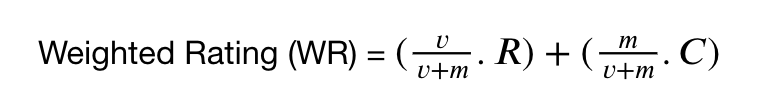

where,

v - Number of people who have rated the movie (vote_count)\
m - Minimum number of ratings required to be listed in the chart\
R - Average rating of the movie (vote_average)\
C - Mean of ratings across the whole dataset

We already have the values for v and R. Now, we need to calculate m and C in order to get the top N movies. For calculating m, we can use the 95th percentile as our cutoff. In other words, for a movie to feature in the top N list, it needs to have more votes than at least 95% of the movies in the list.

### <font color='green'>2.1 Creating a simple recommender system to show the top N movies at an overall level

In [27]:
# Getting values m and C

m = round(md['vote_count'].quantile(0.95))
C = round(md['vote_average'].mean(), 1)

In [28]:
print(m)
print(C)

438
5.6


In [29]:
# Filtering the dataset to only select those movies having atleast 438 as vote_count and selecting only the relevant features for this system

simple_recommender_1 = md[(md['vote_count'] >= m)][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres', 'overview']]
simple_recommender_1.shape

(2255, 7)

We end up with 2255 movies, which would be used to create the top N movies.

In [30]:
# Creating a function to find the weighted rating based on the IMDB formula

def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return round((v*R/(v+m)) + (m*C/(m+v)),1)

In [31]:
simple_recommender_1['weighted_rating'] = simple_recommender_1.apply(weighted_rating, axis=1)

In [32]:
simple_recommender_1.head()

,title,year,vote_count,vote_average,popularity,genres,overview,weighted_rating
0,Toy Story,1995,5415.0,7.7,21.946943,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...",7.5
1,Jumanji,1995,2413.0,6.9,17.015539,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,6.7
5,Heat,1995,1886.0,7.7,17.924927,"[Action, Crime, Drama, Thriller]","Obsessive master thief, Neil McCauley leads a ...",7.3
9,GoldenEye,1995,1194.0,6.6,14.686036,"[Adventure, Action, Thriller]",James Bond must unmask the mysterious head of ...,6.3
15,Casino,1995,1343.0,7.8,10.137389,"[Drama, Crime]",The life of the gambling paradise – Las Vegas ...,7.3


In [33]:
simple_recommender_1.sort_values(['weighted_rating', 'year'], ascending= [False, False], inplace = True)

In [34]:
# Showing the top 15 movies as recommendations

simple_recommender_1.head(15)

,title,year,vote_count,vote_average,popularity,genres,overview,weighted_rating
314,The Shawshank Redemption,1994,8358.0,8.5,51.645403,"[Drama, Crime]",Framed in the 1940s for the double murder of h...,8.4
834,The Godfather,1972,6024.0,8.5,41.109264,"[Drama, Crime]","Spanning the years 1945 to 1955, a chronicle o...",8.3
12481,The Dark Knight,2008,12269.0,8.3,123.167259,"[Drama, Action, Crime, Thriller]",Batman raises the stakes in his war on crime. ...,8.2
2843,Fight Club,1999,9678.0,8.3,63.869599,[Drama],A ticking-time-bomb insomniac and a slippery s...,8.2
292,Pulp Fiction,1994,8670.0,8.3,140.950236,"[Thriller, Crime]","A burger-loving hit man, his philosophical par...",8.2
23673,Whiplash,2014,4376.0,8.3,64.29999,[Drama],"Under the direction of a ruthless instructor, ...",8.1
351,Forrest Gump,1994,8147.0,8.2,48.307194,"[Comedy, Drama, Romance]",A man with a low IQ has accomplished great thi...,8.1
522,Schindler's List,1993,4436.0,8.3,41.725123,"[Drama, History, War]",The true story of how businessman Oskar Schind...,8.1
22879,Interstellar,2014,11187.0,8.1,32.213481,"[Adventure, Drama, Science Fiction]",Interstellar chronicles the adventures of a gr...,8.0
18465,The Intouchables,2011,5410.0,8.2,16.086919,"[Drama, Comedy]",A true story of two men who should never have ...,8.0


We see that 'The Shawshank Redemption', 'The Godfather' and 'The Dark Knight' are the top 3 movies based on our dataset. Not a bad list of movies to suggest for someone who's new to the system!

Let us now create a function that can take in the genre, the percentile and the N count and return the top N movies in that genre accordingly. 

### <font color='green'>2.2 Creating a simple recommender system to show the top N movies based on genre

In [35]:
def simple_recommender(N, genre = '', percentile = 0.95):
    df = md.copy()
    if genre:
        df['genre_flag'] = df['genres'].apply(lambda x: 1 if x.count(genre) > 0 else 0)        
        df = df[df['genre_flag'] == 1]
    
    m = round(df['vote_count'].quantile(percentile))
    C = round(df['vote_average'].mean(), 1)
    
    simple_recommender = df[(df['vote_count'] >= m)][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
    
    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return round((v*R/(v+m)) + (m*C/(m+v)),1)
    
    simple_recommender['weighted_rating'] = simple_recommender_1.apply(weighted_rating, axis=1)
    simple_recommender.sort_values(['weighted_rating', 'year'], ascending= [False, False], inplace = True)
    
    return simple_recommender.head(N)

If we keep the genre as null and get the top 15 movies, we get the same result we got earlier.

In [36]:
simple_recommender(N = 15)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
314,The Shawshank Redemption,1994,8358.0,8.5,51.645403,"[Drama, Crime]",8.4
834,The Godfather,1972,6024.0,8.5,41.109264,"[Drama, Crime]",8.3
12481,The Dark Knight,2008,12269.0,8.3,123.167259,"[Drama, Action, Crime, Thriller]",8.2
2843,Fight Club,1999,9678.0,8.3,63.869599,[Drama],8.2
292,Pulp Fiction,1994,8670.0,8.3,140.950236,"[Thriller, Crime]",8.2
23673,Whiplash,2014,4376.0,8.3,64.29999,[Drama],8.1
351,Forrest Gump,1994,8147.0,8.2,48.307194,"[Comedy, Drama, Romance]",8.1
522,Schindler's List,1993,4436.0,8.3,41.725123,"[Drama, History, War]",8.1
22879,Interstellar,2014,11187.0,8.1,32.213481,"[Adventure, Drama, Science Fiction]",8.0
18465,The Intouchables,2011,5410.0,8.2,16.086919,"[Drama, Comedy]",8.0


Let's check for the 'Horror' genre to see what movies we get.

In [37]:
simple_recommender(N = 10, genre = 'Horror', percentile = 0.95)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
1213,The Shining,1980,3890.0,8.1,19.611589,"[Horror, Thriller]",7.8
1176,Psycho,1960,2405.0,8.3,36.826309,"[Drama, Horror, Thriller]",7.8
1171,Alien,1979,4564.0,7.9,23.37742,"[Horror, Action, Thriller, Science Fiction]",7.6
1158,Aliens,1986,3282.0,7.7,21.761179,"[Horror, Action, Thriller, Science Fiction]",7.4
2175,The Thing,1982,1629.0,7.8,16.83125,"[Horror, Mystery, Science Fiction]",7.2
1338,Jaws,1975,2628.0,7.5,19.726114,"[Horror, Thriller, Adventure]",7.2
21276,The Conjuring,2013,3169.0,7.4,14.90169,"[Horror, Thriller]",7.1
8147,Shaun of the Dead,2004,2479.0,7.5,14.902948,"[Horror, Comedy]",7.1
1888,The Exorcist,1973,2046.0,7.5,12.137595,"[Drama, Horror, Thriller]",7.1
14236,Zombieland,2009,3655.0,7.2,11.063029,"[Comedy, Horror]",7.0


These are some top tier horror movies and any horro genre fan would be delighted to have these movies as recommendations. 

## <font color='green'>Section 3 - Content Based Recommender System

Now that we are done looking at the Simple Recommendation system, let's take a look at creating personalized recommendations with the help of Content Based Recommender. 

The recommender we built in the previous section had a broad appeal but suffers from the fact that it doesn't offer a personalized solution to a user. It gives the same recommendations to everyone, regardless of the user's personal taste. Thus, to personalize our recommendations, we can take relevant inputs like movie content, genre, etc which would give much better suggestions for a given user. Such a system is called as a Content Based Recommender.

These systems make recommendations using a user's item and profile features. They hypothesize that if a user was interested in an item in the past, they will once again be interested in it in the future. Similar items are usually grouped based on their features. User profiles are constructed using historical interactions or by explicitly asking users about their interests. There are other systems, not considered purely content-based, which utilize user personal and social data.

The thinking behind using these features is that if a user A likes the movie 'The Dark Knight', it is highly possible that he would be interested in other Batman movies/other Nolan movies/Other Bale movies. So in order to find such movies, we first extract the relevant information about the movie that we need (keywords, overview, cast, etc.), and use that information to find the similarity between our user liked movie and other movies in our list and recommend the movies that are highly similar to the user liked movie. 
    
In this section, we will be building two Content Based Recommenders based on:

Movie Overviews\
Movie Cast, Director, Keywords and Genre
    
#### <font color='green'>Steps Involved:
    
1) The first step is to create a so-called ‘bag of words’ model from the input data, which is a list of words used to characterize the items. This step involves selecting useful content for describing and differentiating the items. The more precise the information, the better will be the recommendations
2) The next step is to turn the bag (of words) into a feature vector. Different algorithms can be used for this step, for example, the Tfdif vectorizer or the count vectorizer. We will be using SBERT. The result is a vector matrix with items as records and features as columns. This step often also includes applying techniques for dimensionality reduction. But in our case we won't be doing that as SBERT already has a maximum word_embedding_dimension which restricts it to a preset limit (768 in our case). So dimensionality reduction won't be needed as the number of dimensions would already be small.
3) The idea of content-based recommendations is based on measuring item similarity. Similarity scores are assigned through pairwise comparison. Here again, we have the choice between different measures, e.g., the dot product or cosine similarity
4) Once you have the similarity scores, you can return the most similar items by sorting the data by similarity scores. Given user preferences (single or multiple items a user consumed or liked), the algorithm will then recommend the most similar items

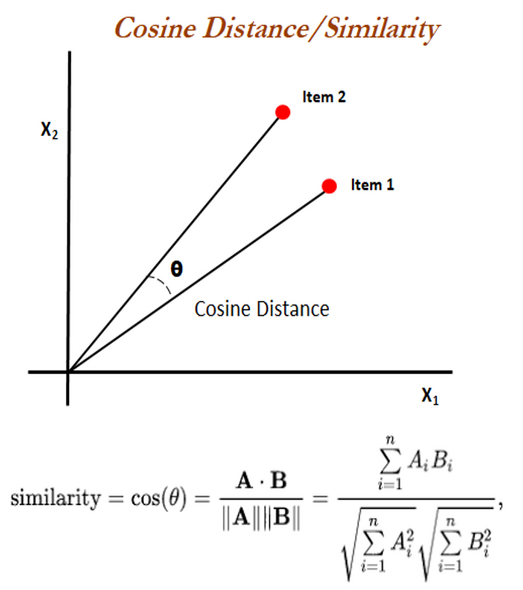

Image source - https://www.tyrrell4innovation.ca/miword-of-the-day-iscosine-distance/

    
#### <font color='green'>SBERT

We will be making use of SBERT (https://www.pinecone.io/learn/sentence-embeddings/#:~:text=Unlike%20BERT%2C%20SBERT%20is%20fine,sentence%20A%20and%20sentence%20B) to convert our content into vectors. 
The reason being that fine-tuned BERT classifiers outperform bag-of-words-based classifiers (https://link.springer.com/article/10.1007/s10660-022-09560-w). Most online material I have seen, have used TF-IDF to perform the vectorization. But since it's clear that BERT has better performance, we will be using BERT. Within BERT, we will be using the SBERT model 'all-mpnet-base-v2' as it has the best performance for sentence embeddings.
    
One thing to note is that, our SBERT model ('all-mpnet-base-v2') has a maximum sequence length of 384, which means that if our input is greater than 384, it will get truncated. But this shouldn't affect the recommendations too much.  

### <font color='green'>3.1 Movie Overview Based Recommender

Instead of taking the entire 46K movies for consideration, we will be taking only those movies in the top 95 percentile in terms of number of votes received for 2 reasons:

1) Processing time will be faster (since we're running this on our personal computer rather than a production environment
2) Most users prefer mainstream and popular movies that match their tastes for their suggestions than movies with very few ratings or appeal (keywords being 'most users' and not all)

In [149]:
m = round(md['vote_count'].quantile(0.95))  # You can change the percentiles to see how the result changes
C = round(md['vote_average'].mean(), 1)
    
df = md[(md['vote_count'] >= m)][['id', 'title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres', 'overview']]

df.shape

(2255, 8)

In [150]:
# Need high processing power and would take ~30 mins to run for the entire 46K dataset. But in our case, for the 2,255 movies, it takes a couple of minutes

text_data = np.array(df['overview'])
model = SentenceTransformer('all-mpnet-base-v2') # All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs.
embeddings = model.encode(text_data, show_progress_bar=True)

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

In [151]:
model.get_sentence_features

<bound method SentenceTransformer.get_sentence_features of SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: MPNetModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)>

We can see that the model we chose has a max seq length of 384 and the word embedding dimension of 768.

In [152]:
# Almost 1/4th of our data (531/2255) would get truncated as it exceeds the max_seq_length of 384. But it shouldn't affect the performance too much.

i = [len(i) for i in text_data if len(i) > 384]
len(i)

531

In [153]:
embeddings.shape

(2255, 768)

In [154]:
# Can take 15-20 mins to run if we use the entire 46K dataset. In our case of 2,255 movies, it takes a few secs

cos_sim_data = pd.DataFrame(cosine_similarity(embeddings))

In [155]:
df = df.reset_index()
data = df[['title','genres','year']]
indices = pd.Series(df.index, index=df['title'])

In [159]:
def get_recommendations(title, N = 30):
    idx = indices[title]
    sim_scores = list(enumerate(cos_sim_data[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    movie_indices = [i[0] for i in sim_scores]
    sim_scores = pd.DataFrame(sim_scores, columns = ['index', 'similarity_score']) 
    final_data = data.iloc[movie_indices]
    final_data = final_data.merge(sim_scores, left_index = True, right_on ='index')
    final_data['similarity_score'] = round(final_data['similarity_score']*100,2)
    del final_data['index']
    return final_data

In [160]:
get_recommendations('The Godfather', 15)

,title,genres,year,similarity_score
0,The Godfather: Part III,"[Crime, Drama, Thriller]",1990,70.66
1,The Godfather: Part II,"[Drama, Crime]",1974,69.92
2,The Sting,"[Comedy, Crime, Drama]",1973,60.85
3,Gangster Squad,"[Crime, Drama, Action, Thriller]",2013,53.01
4,Mr. Holmes,"[Drama, Mystery]",2015,52.37
5,Black Mass,"[Crime, Drama]",2015,50.14
6,A Most Violent Year,"[Crime, Drama, Thriller]",2014,50.11
7,American Hustle,"[Drama, Crime]",2013,49.46
8,Miami Vice,"[Action, Adventure, Crime, Thriller]",2006,49.28
9,GoodFellas,"[Drama, Crime]",1990,49.01


In [161]:
get_recommendations('The Notebook', 15)

,title,genres,year,similarity_score
0,Closer,"[Drama, Romance]",2004,68.53
1,Gone with the Wind,"[Drama, Romance, War]",1939,67.46
2,Sleepless in Seattle,"[Comedy, Drama, Romance]",1993,66.73
3,Before Sunrise,"[Drama, Romance]",1995,66.32
4,Moonlight,[Drama],2016,64.76
5,Mystic River,"[Thriller, Crime, Drama, Mystery]",2003,63.70
6,Crimson Peak,"[Mystery, Thriller, Fantasy, Horror, Drama]",2015,63.15
7,Legends of the Fall,"[Adventure, Drama, Romance, War]",1994,62.75
8,Cold Mountain,[Drama],2003,62.56
9,The Visit,"[Horror, Thriller]",2015,62.00



Despite truncating 1/4th of our input data, we're getting excellent recommendations for the chosen movies. But we can notice that the recommendations for 'The Godfather' still has some movies that aren't relevant like 'Bad Boys 2'

Similarly, for the movie 'The Notebook', we can see movies like 'Mystic River', 'Crimson Peak' that don't have much in common. 

So, we need to further improve our technique. Let's make use of movie metadata other than description to improve our recommendations. We will be taking the following information to see if it improves our recommendations:
- Genre
- Keywords
- Top 5 Cast
- Director

### <font color='green'>3.2 Movie Metadata Based Recommender

In [162]:
# Loading in the credits and keywords data 

credits = pd.read_csv('C:/Users/balaj/Downloads/archive/credits.csv')
keywords = pd.read_csv('C:/Users/balaj/Downloads/archive/keywords.csv')

In [163]:
# Removing duplicates from the data

credits.drop_duplicates(inplace = True)
keywords.drop_duplicates(inplace = True)

In [164]:
# Changing the datatype of id to int to enable merging

keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
df['id'] = df['id'].astype('int')

In [165]:
df = df.merge(credits, on='id')
df = df.merge(keywords, on='id')

In [166]:
df.shape

(2255, 12)

In [167]:
df.head()

,index,id,title,year,vote_count,vote_average,popularity,genres,overview,cast,crew,keywords
0,0,862,Toy Story,1995,5415.0,7.7,21.946943,"[Animation, Comedy, Family]","Led by Woody, Andy's toys live happily in his ...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,1,8844,Jumanji,1995,2413.0,6.9,17.015539,"[Adventure, Fantasy, Family]",When siblings Judy and Peter discover an encha...,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,5,949,Heat,1995,1886.0,7.7,17.924927,"[Action, Crime, Drama, Thriller]","Obsessive master thief, Neil McCauley leads a ...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...","[{'id': 642, 'name': 'robbery'}, {'id': 703, '..."
3,9,710,GoldenEye,1995,1194.0,6.6,14.686036,"[Adventure, Action, Thriller]",James Bond must unmask the mysterious head of ...,"[{'cast_id': 1, 'character': 'James Bond', 'cr...","[{'credit_id': '52fe426ec3a36847f801e14b', 'de...","[{'id': 701, 'name': 'cuba'}, {'id': 769, 'nam..."
4,15,524,Casino,1995,1343.0,7.8,10.137389,"[Drama, Crime]",The life of the gambling paradise – Las Vegas ...,"[{'cast_id': 4, 'character': ""Sam 'Ace' Rothst...","[{'credit_id': '52fe424dc3a36847f80139cd', 'de...","[{'id': 383, 'name': 'poker'}, {'id': 726, 'na..."


In [168]:
# Getting the cast names and keeping only the top 5 main cast in the list

df['cast'] = df['cast'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
df['cast'] = df['cast'].apply(lambda x: x[:5] if len(x) >=5 else x)

In [169]:
# Getting the keywords and storing it in a list

df['keywords'] = df['keywords'].apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [170]:
# Getting the director name 

def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

df['director'] = df['crew'].apply(literal_eval).apply(get_director)

In [171]:
# Removing space between names in order to differentiate between different actors and directors

df['cast'] = df['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
df['director'] = df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

In [172]:
# Changing the datatype to list to enable concatenation
df['director'] = df['director'].apply(lambda x: [i for i in x.split()])

# Creating a new column by concatenating all the relavant metadata info
df['metadata'] = df['genres'] + df['keywords'] + df['director'] + df['cast']

# Taking all the items in the metadata and joining it into a single string
df['metadata'] = df['metadata'].apply(lambda x: ' '.join(x))

In [173]:
meta_data = np.array(df['metadata'])
model = SentenceTransformer('all-mpnet-base-v2') # All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs.
embeddings = model.encode(meta_data, show_progress_bar=True)

Batches:   0%|          | 0/71 [00:00<?, ?it/s]

In [175]:
# This time we're truncating only 46 datapoints out of 2255 which shouldn't affect the performance

i = [len(i) for i in meta_data if len(i) > 384]
len(i)

46

In [176]:
embeddings.shape

(2255, 768)

In [177]:
cos_sim_data = pd.DataFrame(cosine_similarity(embeddings))

In [182]:
# Function already define in the previous section. So just reusing it. But re-running the pre-requisites for the function

df = df.reset_index()
data = df[['title','genres','year']]
indices = pd.Series(df.index, index=df['title'])

get_recommendations('The Godfather', 15)

,title,genres,year,similarity_score
0,The Godfather: Part II,"[Drama, Crime]",1974,71.20
1,A Bronx Tale,"[Drama, Crime]",1993,68.31
2,Analyze This,"[Comedy, Crime]",1999,65.09
3,The Godfather: Part III,"[Crime, Drama, Thriller]",1990,64.47
4,Cinema Paradiso,"[Drama, Romance]",1988,62.64
5,GoodFellas,"[Drama, Crime]",1990,59.97
6,John Wick: Chapter 2,"[Thriller, Action, Crime]",2017,59.28
7,The Family,"[Crime, Comedy, Action]",2013,56.40
8,A Walk Among the Tombstones,"[Crime, Drama, Mystery, Thriller]",2014,55.55
9,Meet the Fockers,"[Comedy, Romance]",2004,54.84


In [179]:
get_recommendations('The Dark Knight', 15)

,title,genres,year,similarity_score
0,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",2012,92.69
1,Batman: The Killing Joke,"[Action, Animation, Crime, Drama]",2016,87.03
2,Suicide Squad,"[Action, Adventure, Crime, Fantasy, Science Fi...",2016,82.09
3,Batman v Superman: Dawn of Justice,"[Action, Adventure, Fantasy]",2016,80.82
4,Batman Begins,"[Action, Crime, Drama]",2005,79.81
5,Batman: Under the Red Hood,"[Action, Animation]",2010,79.66
6,Batman Returns,"[Action, Fantasy]",1992,79.24
7,Dredd,"[Action, Science Fiction]",2012,79.06
8,Superman,"[Action, Adventure, Fantasy, Science Fiction]",1978,78.43
9,Batman & Robin,"[Action, Crime, Fantasy]",1997,76.82


As we can see now, the recommendations seem to make much more sense and are more in line with the given movie. We can further give better recommendations by combining our content based recommendations with our ratings, which you can find below.

In [197]:
def get_recommendations_final(title, N = 30):
    idx = indices[title]
    sim_scores = list(enumerate(cos_sim_data[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:N+1]
    movie_indices = [i[0] for i in sim_scores]
    sim_scores = pd.DataFrame(sim_scores, columns = ['index', 'similarity_score']) 

    movies = df.iloc[movie_indices][['title', 'genres', 'vote_count', 'vote_average', 'year']]
    final_data = movies.merge(sim_scores, left_index = True, right_on ='index')
    final_data['similarity_score'] = round(final_data['similarity_score']*100,2)
    del final_data['index']
    
    m = round(df['vote_count'].quantile(0.95))
    C = round(df['vote_average'].mean(), 1)
    
    def weighted_rating(x):
        v = x['vote_count']
        R = x['vote_average']
        return round((v*R/(v+m)) + (m*C/(m+v)),1)
    
    final_data['weighted_rating'] = final_data.apply(weighted_rating, axis=1)
    final_data.sort_values(['weighted_rating', 'year'], ascending= [False, False], inplace = True)
    
    return final_data.head(N)

In [208]:
get_recommendations_final('The Dark Knight', 15)

,title,genres,vote_count,vote_average,year,similarity_score,weighted_rating
0,The Dark Knight Rises,"[Action, Crime, Drama, Thriller]",9263.0,7.6,2012,92.69,7.3
4,Batman Begins,"[Action, Crime, Drama]",7511.0,7.5,2005,79.81,7.1
14,Kick-Ass,"[Action, Crime]",4747.0,7.1,2010,75.49,6.8
5,Batman: Under the Red Hood,"[Action, Animation]",459.0,7.6,2010,79.66,6.7
11,Watchmen,"[Action, Mystery, Science Fiction]",2892.0,7.0,2009,76.48,6.7
8,Superman,"[Action, Adventure, Fantasy, Science Fiction]",1042.0,6.9,1978,78.43,6.7
1,Batman: The Killing Joke,"[Action, Animation, Crime, Drama]",485.0,6.2,2016,87.03,6.6
7,Dredd,"[Action, Science Fiction]",1971.0,6.6,2012,79.06,6.6
6,Batman Returns,"[Action, Fantasy]",1706.0,6.6,1992,79.24,6.6
10,Man of Steel,"[Action, Adventure, Fantasy, Science Fiction]",6462.0,6.5,2013,76.65,6.5


Based on these new recommendations, it's clear that this looks like a better set of suggestions which incorporates both content based metadata as well as the ratings of the movies. 

But one thing you can notice is that, in the example above, we recommended movies based on a user's preference of a single movie. In reality, during recommendation, the user would have watched a lot of different movies and hence would have a varied taste. Let's create a recommendation system for this scenario.

In [254]:
movie_list = ['The Lion King', 'Se7en', 'Toy Story', 'Blade Runner', 'Quantum of Solace', 'Casino Royale', 'Skyfall']

# Getting the top N movies of each of the movies watched by our user and then summing the similarity score and sorting them

user_scores = pd.DataFrame(df[['title', 'year', 'genres']])
user_scores['similarity_score'] = 0.0
N = 15

for movie_name in movie_list:
    top_titles_df = get_recommendations(movie_name, N)
    user_scores = pd.concat([user_scores, top_titles_df[['title', 'similarity_score']]]).groupby(['title'], as_index=False).sum({'similarity_score'})

# Sort and print the aggregated scores
user_scores.sort_values(by='similarity_score', ascending=False)[:N]

,title,year,similarity_score
1469,Spectre,2015,163.67
611,From Russia with Love,1963,162.27
2050,Tomorrow Never Dies,1997,156.71
1891,The November Man,2014,155.87
161,Atomic Blonde,2017,155.45
1356,Salt,2010,152.12
1147,On Her Majesty's Secret Service,1969,151.17
2024,The World Is Not Enough,1999,150.12
910,La Femme Nikita,1990,149.23
266,Bolt,2008,148.80


This final list of recommendation definitely covers most Bond movies/Action movies and also has a few animated movies which resembles our user's watched movies list. Hopefully, this gives you a good idea about Content Based Recommendation systems. Finally, let's look at the pros and cons of Content based systems:

<b>Pros:
- Content-based filtering does not require other users' data during recommendations to one user
- Can provide explanations of recommended items by listing content-features	that caused	an item	to be recommended

<b>Cons:
- One issue that is clearly visible and which generally arises in Content based systems is making obvious recommendations because of over-specialization (user A is only interested in categories B, C, and D, and the system is not able to recommend items outside those categories, even though they could be interesting to them)
- It is only capable of suggesting movies which are close to a certain movie/genre based on the user's watching history. It is not capable of capturing tastes and providing recommendations across genres
- Hard to give recommendations for new users

Now that we have seen how Content Based Recommender systems work, let's turn our attention towards Collaborative Filtering system. 

## <font color='green'>Section 4 - Collaborative Filtering System<font>

Collaborative filtering is currently one of the most frequently used approaches and usually provides better results than content-based recommendations. Some examples of this are found in the recommendation systems of Youtube, Netflix, and Spotify.

These kinds of systems utilize user interactions to filter for items of interest. We can visualize the set of interactions with a matrix, where each entry (i, j)(i,j) represents the interaction between user ii and item jj. An interesting way of looking at collaborative filtering is to think of it as a generalization of classification and regression. While in these cases we aim to predict a variable that directly depends on other variables (features), in collaborative filtering there is no such distinction of feature variables and class variables.

Visualizing the problem as a matrix, we don’t look to predict the values of a unique column, but rather to predict the value of any given entry.

In short, collaborative filtering systems are based on the assumption that if a user likes item A and another user likes the same item A as well as another item, item B, the first user could also be interested in the second item. Hence, they aim to predict new interactions based on historical ones. There are two types of methods to achieve this goal: memory-based and model-based.

### <font color='green'>Memory-based
There are two approaches: the first one identifies clusters of users and utilizes the interactions of one specific user compared to the interactions of other similar users to create recommendations (<b>User-Based</b>). The second approach identifies clusters of items that are similar to a given item and recommends the top items that resemble the item rated by a particular user (<b>Item-Based</b>). These methods usually encounter major problems with large sparse matrices, since the number of user-item interactions can be too low for generating high quality clusters.

To summarize -

User Based Collaborative Filtering: “Users who are similar to you also liked"\
Item Based Collaborative Filtering: “Users who liked this item also liked”

### <font color='green'>Model-based
These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory-based. We say they have large coverage, even when working with large sparse matrices.

## <font color='green'>4.1 Memory-Based Systems</font>

### <font color='green'>4.1.1 User-Based Collaborative Filtering</font>

User-based collaborative filtering algorithm usually has the following steps:

1) Find similar users based on interactions with common items
2) Identify the items rated high by similar users but have not been exposed to the active user of interest
3) Calculate the weighted average score for each item
4) Rank items based on the score and pick the top n items to recommend

In [255]:
# Loading user level data. We are loading just a small subset of the user ratings data. The actual data is 700 MB large and hence would take a long time to run our analyses

user_data = pd.read_csv('C:/Users/balaj/Downloads/archive/ratings_small.csv')
user_data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [256]:
user_data.shape

(100004, 4)

In [257]:
user_data['userId'].nunique()

671

In [258]:
user_data['movieId'].nunique()

9066

In [259]:
sorted(user_data['rating'].unique())

[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]

We can see that there are a total of 100K ratings records from 671 users for 9,066 movies. The ratings range from 0.5 - 5. In order to bring more context to the data, let's merge our user data with the movie data.

In [260]:
# Merging the user data with movie data

user_data['movieId'] = user_data['movieId'].astype(int)
md['id'] = md['id'].astype(int)
user_data = user_data.merge(md[['title', 'genres', 'year', 'id']], how = 'inner', left_on = 'movieId', right_on = 'id')

In [261]:
user_data.tail()

,userId,movieId,rating,timestamp,title,genres,year,id
44934,652,129009,4.0,1442690827,Love Is a Ball,"[Comedy, Romance]",1963,129009
44935,653,2103,3.0,948161066,Solaris,"[Drama, Science Fiction, Mystery, Romance]",2002,2103
44936,659,167,4.0,836137550,K-PAX,"[Drama, Science Fiction]",2001,167
44937,659,563,3.0,834694187,Starship Troopers,"[Adventure, Action, Thriller, Science Fiction]",1997,563
44938,665,129,3.0,995232528,Spirited Away,"[Fantasy, Adventure, Animation, Family]",2001,129


In [262]:
user_data.shape

(44939, 8)

In [263]:
user_data['movieId'].nunique()

2817

In [264]:
agg_ratings = user_data.groupby('title').agg(mean_rating = ('rating', 'mean'), number_of_ratings = ('rating', 'count')).reset_index()

In [265]:
agg_ratings.head()

,title,mean_rating,number_of_ratings
0,!Women Art Revolution,3.25,2
1,'Gator Bait,0.50,1
2,'Twas the Night Before Christmas,4.00,2
3,...And God Created Woman,4.00,1
4,00 Schneider - Jagd auf Nihil Baxter,4.00,2


We can clearly see that there are a lot of movies where only 1 person has rated. So, we need to filter and keep only those movies with over a minimum of 95 percentile number of ratings for the analysis. 

In [266]:
val = round(agg_ratings['number_of_ratings'].quantile(0.95))
val

71

In [267]:
# Filtering for movies with over 71 ratings

agg_ratings_final = agg_ratings[agg_ratings['number_of_ratings'] > val]
agg_ratings_final.shape

(139, 3)

In [268]:
agg_ratings_final.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
1952,Terminator 3: Rise of the Machines,4.256173,324
2297,The Million Dollar Hotel,4.487138,311
1831,Solaris,4.134426,305
1960,The 39 Steps,4.221649,291
1370,Monsoon Wedding,3.706204,274


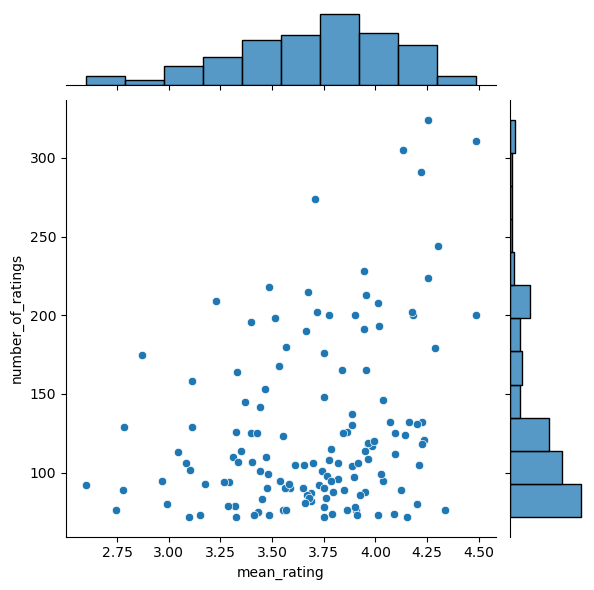

In [269]:
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_final)

After applying the filters, we end up with 139 movies. Plotting the avg ratings vs the number of ratings, we can see that most movies have less than 100 ratings. You can also see a slightly positive correlation between the two.

Let's join the agg_ratings_final dataset with the user_data and proceed further.

In [270]:
user_data_final = pd.merge(user_data, agg_ratings_final[['title']], on='title', how='inner')
user_data_final.shape

(17629, 8)

In [271]:
user_data_final['userId'].nunique()

658

In [272]:
user_data_final.head()

,userId,movieId,rating,timestamp,title,genres,year,id
0,2,17,5.0,835355681,The Dark,"[Horror, Thriller, Mystery]",2006,17
1,9,17,4.0,938628337,The Dark,"[Horror, Thriller, Mystery]",2006,17
2,15,17,3.0,997939404,The Dark,"[Horror, Thriller, Mystery]",2006,17
3,18,17,4.0,856006886,The Dark,"[Horror, Thriller, Mystery]",2006,17
4,44,17,2.0,858707139,The Dark,"[Horror, Thriller, Mystery]",2006,17


After filtering the movies with over 71 ratings, we have 658 users that rated 139 movies. Now, we can transform the dataset into a matrix format. The rows of the matrix are users, and the columns of the matrix are movies. The value of the matrix is the user rating of the movie if there is a rating. Otherwise, it shows ‘NaN’.

In [273]:
matrix = user_data_final.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,"20,000 Leagues Under the Sea",2001: A Space Odyssey,48 Hrs.,5 Card Stud,A Clockwork Orange,A Nightmare on Elm Street,A River Runs Through It,Aguirre: The Wrath of God,Aliens vs Predator: Requiem,All the Way Boys,...,To Kill a Mockingbird,Tough Enough,Twin Peaks: Fire Walk with Me,Under the Sand,Wag the Dog,Waiter,Who Killed Bambi?,Will Penny,Y Tu Mamá También,Young and Innocent
userId,,,,,,,,,,,,,,,,,,,,,
2,NaN,3.0,5.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,4.5,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
4,3.0,NaN,NaN,NaN,3.0,NaN,NaN,5.0,4.0,NaN,...,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,4.0,NaN,NaN,4.0,4.0,...,4.0,NaN,4.5,NaN,4.0,3.0,NaN,NaN,NaN,3.5
6,2.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since some people tend to give a higher rating than others, we perform something called as mean-centering where we subtract each rating of a user with their average rating. (null values are not included)

After mean-centering, the movies with a rating less than the user’s average rating get a negative value, and the movies with a rating more than the user’s average rating get a positive value thereby effectively differentiating users' preferences.

In [317]:
matrix_norm = round(matrix.subtract(matrix.mean(axis=1), axis = 'rows'),2)
matrix_norm = matrix_norm.fillna(0)
matrix_norm.head()

title,"20,000 Leagues Under the Sea",2001: A Space Odyssey,48 Hrs.,5 Card Stud,A Clockwork Orange,A Nightmare on Elm Street,A River Runs Through It,Aguirre: The Wrath of God,Aliens vs Predator: Requiem,All the Way Boys,...,To Kill a Mockingbird,Tough Enough,Twin Peaks: Fire Walk with Me,Under the Sand,Wag the Dog,Waiter,Who Killed Bambi?,Will Penny,Y Tu Mamá También,Young and Innocent
userId,,,,,,,,,,,,,,,,,,,,,
2,0.00,-0.6,1.4,0.0,-0.60,-0.60,0.0,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,-0.6,0.0,0.00,0.0,0.0,0.00
3,0.00,0.0,0.0,0.0,0.00,-1.09,0.0,0.00,0.00,0.91,...,-1.59,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,-0.09
4,-1.46,0.0,0.0,0.0,-1.46,0.00,0.0,0.54,-0.46,0.00,...,0.00,-0.46,0.0,0.0,0.0,0.0,-0.46,0.0,0.0,0.00
5,0.00,0.0,0.1,0.0,0.00,0.10,0.0,0.00,0.10,0.10,...,0.10,0.00,0.6,0.0,0.1,-0.9,0.00,0.0,0.0,-0.40
6,-1.50,0.0,0.0,0.0,0.00,0.00,1.5,0.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00


There are different ways to measure similarities. Pearson correlation and Cosine similarity are two widely used methods. Let's continue to use cosine_similarity. Since cosine_similarity does not take missing values, we need to impute the missing values with 0s before the calculation (which we have done above).

Let's write a function to find the K nearest users to a given user using cosine similarity. We can give 5 as the default value for K

In [386]:
def similar_users_fn(user_id, matrix, K=5):
    
    # Create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # Create a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # Get cosine similarity between user and each of the other users
    similarities = cosine_similarity(user, other_users)[0].tolist()
    
    # Create list of ids of these users
    ids = other_users.index.tolist()
    
    # Create key/values pairs of user id and their similarity
    id_similarity = dict(zip(ids, similarities))
    
    # Sort by similarity (desc)
    id_similarity_sorted = [(k, v) for k, v in sorted(id_similarity.items(), key=lambda item: item[1], reverse = True)]
    
    # Grab k users off the top
    users = [u for u in id_similarity_sorted[:K]]
    
    return users

In [447]:
user = 39
similar_user_ids = similar_users_fn(user, matrix_norm)
similar_user_ids

[(3, 0.3852231156101469),
 (172, 0.3780694011718894),
 (590, 0.3550867328698299),
 (24, 0.352145671884849),
 (267, 0.3029029187104928)]

Finally, let's write a function to give the recommendations. We can once again set the function to return the 5 top recommended movies by default. Here we will be using the weighted average to calculate the ratings of each movie so that users who have high similarity score to the given user have a higher weight on ratings. Then we pick only those movies which our user hasn't watched, sort them by the weighted average and suggest them as recommendations.

In [543]:
def user_based_recommender(user_id, matrix, items=5, users=5):
    
    similar_user_ids_and_ratings = pd.DataFrame(similar_users_fn(user_id, matrix, users), columns = ['similar_user_ids', 'similarity_score'])
    
    # Load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_ids_and_ratings['similar_user_ids'])]
    similar_users = similar_users.merge(similar_user_ids_and_ratings, left_on = 'userId', right_on = 'similar_user_ids')
    
    # Calc weighted avg ratings for movies across the N similar users
    cols = similar_users.columns[:-2]
    final_ratings = {}
    for movie in cols:
        final_ratings[movie] = round(np.average(similar_users[movie], axis = 0, weights = similar_users['similarity_score']),2)
    
    # Convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(final_ratings.items(), columns = ['title', 'weighted_average'])
      
    # Load vector for the current user
    user_df = matrix[matrix.index == user_id]
    
    # Transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    
    # Rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    
    # Get only those movies with rating as 0 since the user has not watched them yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    
    # Convert it into a list which contains movies the user has not seen
    movies_unseen = user_df_transposed.index.tolist()
    
    # Filter weighted avg ratings given by similar users only for those movies the current user has not seen
    similar_users_filtered = similar_users_df[similar_users_df['title'].isin(movies_unseen)]
    
    # Order the dataframe by highest rated movies
    similar_users_df_ordered = similar_users_filtered.sort_values(by=['weighted_average'], ascending=False)
    
#     # Grab the top n movies   
#     top_n_movies = similar_users_df_ordered.head(items)
    
#     # Lookup these movies in the main dataframe containing movie info to get their information
#     movie_information = md[md['title'].isin(top_n_movies['title'])][['id', 'title', 'year', 'vote_average', 'genres']]
    
    return similar_users_df_ordered[:items]

In [546]:
# Top 15 movie recommendations for user with id 39 based on user based recommender system

user_based_recommender(39, matrix_norm, 15)

,title,weighted_average
116,The Million Dollar Hotel,0.73
47,License to Wed,0.37
42,Jarhead,0.27
9,All the Way Boys,0.20
60,Monsieur Hulot's Holiday,0.09
107,The Dark,0.09
86,Say Anything...,0.09
122,The Science of Sleep,0.09
70,Notting Hill,0.09
133,Wag the Dog,0.09


We can see that, depending upon the user that we enter, we get the relevant recommendations without even looking at the characteristics of the movie/users. It looks purely on how a user's ratings match up against other users to create a similarity profile and then selects the top rated movies (which our user hasn't watched) from those users (based on weighted average ratings) as recommendations. Let's now look at item based recommendations.

### <font color='green'>4.1.2 Item-Based Collaborative Filtering 

Item-based collaborative filtering algorithm usually has the following steps:

1) Calculate item similarity scores based on all the user ratings
2) Identify the top N items that are most similar to the item of interest
3) Calculate the weighted average score for the most similar items by the user
4) Rank items based on the score and pick top N items to recommend

Since we are using the same data used in section 4.1.1, we can directly skip the intial steps and create the matrix. But this time the only difference is that we'll have movies as rows and users as columns.

In [445]:
matrix_2 = user_data_final.pivot_table(index='title', columns='userId', values='rating')
matrix_2.head()

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
"20,000 Leagues Under the Sea",NaN,NaN,3.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001: A Space Odyssey,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
48 Hrs.,5.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,3.0,NaN
5 Card Stud,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,NaN,NaN,...,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,NaN,5.0
A Clockwork Orange,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN


We'll do the same steps we did earlier to get the cosine similarity values.

In [446]:
matrix_norm_2 = round(matrix_2.subtract(matrix_2.mean(axis=1), axis = 'rows'),2)
matrix_norm_2 = matrix_norm_2.fillna(0)
matrix_norm_2.head()

userId,2,3,4,5,6,7,8,9,10,11,...,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,
"20,000 Leagues Under the Sea",0.00,0.0,0.24,0.0,-0.76,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00
2001: A Space Odyssey,-0.69,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.0,0.0,0.00,-0.69,0.0,0.0,0.0,0.0,0.0,0.00
48 Hrs.,1.10,0.0,0.00,0.1,0.00,0.0,0.00,0.0,0.0,0.0,...,0.1,0.0,0.00,0.00,0.1,0.1,0.0,0.0,-0.9,0.00
5 Card Stud,0.00,0.0,0.00,0.0,0.00,0.0,-0.68,0.0,0.0,0.0,...,0.0,0.0,-0.18,0.82,0.0,0.0,0.0,0.0,0.0,0.82
A Clockwork Orange,-0.10,0.0,-0.10,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.9,0.0,0.00,0.00,-0.1,-0.1,0.0,0.0,0.0,0.00


Let's write a function to find the top N similar items (movies) to a given item(movie) using cosine similarity. Here we're gonna use the users ratings for different movies to find the similarity between different movies.

In [478]:
def similarity_score(title, matrix):
    
    # create a df of just the given movie
    item = matrix[matrix.index == title]
    
    # and a df of all other movies
    other_items = matrix[matrix.index != title]
    
    # get cosine similarity between given movie and each of the other movies
    other_items['similarity_score'] = cosine_similarity(item, other_items)[0].tolist()
    
    other_items_df = pd.DataFrame(other_items.to_records())
    
    return other_items_df.sort_values(by = 'similarity_score', ascending = False)

In [534]:
movie = 'Persepolis'
similarity_score(movie, matrix_norm_2)

,title,2,3,4,5,6,7,8,9,10,...,663,664,665,666,667,668,669,670,671,similarity_score
90,Silent Light,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,-0.27,0.0,0.00,0.00,0.0,0.00,0.00,0.486193
32,Die Hard 2,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,...,0.0,0.55,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.259884
19,Beauty and the Beast,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,...,0.0,0.97,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.239339
112,The Great Outdoors,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,...,0.0,0.22,0.72,0.0,0.00,0.00,0.0,0.00,0.00,0.234471
135,Will Penny,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,...,0.0,0.90,0.00,0.0,0.00,0.00,0.0,0.00,-0.10,0.224949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,Men in Black II,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.74,0.0,...,0.0,0.00,0.00,0.0,0.74,0.74,0.0,0.74,-0.26,-0.080024
57,Madagascar,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,...,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,-0.093305
97,Superstar: The Karen Carpenter Story,0.0,0.0,1.22,0.00,0.0,0.0,0.22,0.00,0.0,...,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.22,-0.104490
104,The Chronicles of Riddick: Dark Fury,0.0,0.0,1.18,0.00,0.0,0.0,0.68,0.00,0.0,...,0.0,0.00,0.18,0.0,0.00,0.00,0.0,0.00,0.00,-0.106859


In [530]:
def item_based_recommender(user, matrix, items = 5):
    user_watched_movies_df = pd.DataFrame(matrix[(matrix[user] != 0)][user])
    user_watched_movies_df = pd.DataFrame(user_watched_movies_df.to_records())
    user_watched_movies_df_title = user_watched_movies_df['title'].tolist()
    
    user_unwatched_movies_df = pd.DataFrame(matrix[(matrix[user] == 0)][user])
    user_unwatched_movies_df = pd.DataFrame(user_unwatched_movies_df.to_records())
    user_unwatched_movies_title = user_unwatched_movies_df['title'].tolist()
    
    recommendations = {}
    
    for movie in user_unwatched_movies_title:
        sim_matrix = similarity_score(movie, matrix)
        sim_matrix = sim_matrix[sim_matrix['title'].isin(user_watched_movies_df_title)][['title', str(user), 'similarity_score']]
        weighted_rating = round(np.average(sim_matrix[str(user)], axis = 0, weights = sim_matrix['similarity_score']),2)
        recommendations[movie] = weighted_rating
    
    # Convert to dataframe so its easy to sort and filter
    recommendations_df = pd.DataFrame(recommendations.items(), columns = ['title', 'predicted_rating'])
    recommendations_df = recommendations_df.sort_values(by = 'predicted_rating', ascending = False)
    
    return recommendations_df[:items]

In [549]:
# Top 15 movie recommendations for user with id 39 based on item based recommender system

item_based_recommender(39, matrix_norm_2, 15)

,title,predicted_rating
34,Jarhead,1.97
99,The Prisoner of Zenda,0.96
77,Silent Light,0.72
20,Cheerleaders' Wild Weekend,0.65
64,Popular Music,0.64
48,Metropolis,0.62
24,Dave Chappelle's Block Party,0.58
112,Will Penny,0.57
62,Persepolis,0.55
3,A Clockwork Orange,0.54


## <font color='green'>4.2 Model-Based Systems</font>

To perform model-based recommendations, we will be leveraging the Surprise package (https://surpriselib.com/) which is a Python scikit for building and analyzing recommender systems that deal with explicit rating data. Surprise was designed with the following purposes in mind:

- Give users perfect control over their experiments. To this end, a strong emphasis is laid on documentation, which we have tried to make as clear and precise as possible by pointing out every detail of the algorithms.
- Alleviate the pain of Dataset handling. Users can use both built-in datasets (Movielens, Jester), and their own custom datasets.
- Provide various ready-to-use prediction algorithms such as baseline algorithms, neighborhood methods, matrix factorization-based (SVD, PMF, SVD++, NMF), and many others. Also, various similarity measures (cosine, MSD, pearson…) are built-in.
- Make it easy to implement new algorithm ideas.
- Provide tools to evaluate, analyse and compare the algorithms’ performance. Cross-validation procedures can be run very easily using powerful CV iterators (inspired by scikit-learn excellent tools), as well as exhaustive search over a set of parameters.

Firstly, using the Surprise library, we will benchmark all the algorithms present to see how they perform

In [555]:
# We will leverage the final user dataset we created after filtering out those movies with very few ratings

user_data_final.shape

(17629, 8)

In [554]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(user_data_final[['userId', 'movieId', 'rating']], reader)

In [570]:
# Iterating over all algorithms

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

benchmark = []

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Don

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.845180,0.646146,0.902393,0.170426
KNNBaseline,0.849992,0.651349,0.106776,0.617235
SVD,0.862374,0.659420,0.170919,0.024439
BaselineOnly,0.863646,0.663841,0.015027,0.011921
SlopeOne,0.867033,0.658418,0.026541,0.096472
KNNWithZScore,0.871418,0.665853,0.132665,0.499712
KNNWithMeans,0.871554,0.667321,0.090809,0.526504
KNNBasic,0.885144,0.678840,0.074918,0.473591
NMF,0.902617,0.691333,0.187838,0.017557


SVDpp algorithm gives us the best rmse, therefore, we will proceed further with SVDpp.  

We will first train the SVDpp algorithm on our movies data. Then we'll move ahead and predict ratings for all user-item pairs (u, i) that are NOT in the training set. Finally we will create a function that will give N recommendations for a given user using the model we trained.

In [689]:
from collections import defaultdict

# Getting the top N recommendations for all users

def get_top_n(predictions, N):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        N(int): The number of recommendation to output for each user
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:N]

    return top_n

# Creating a function to show the top N recommendations for a given user

def model_based_recommender(user, N = 10):
    
    top_n = get_top_n(predictions, N)
    user_top_n = top_n[user]
    user_top_n_df = pd.DataFrame(user_top_n, columns = ['movieId', 'predicted_rating'])
    user_top_n_df = user_top_n_df.merge(md[['title', 'id']], how = 'inner', left_on = 'movieId', right_on = 'id')
    del user_top_n_df['id']
    return user_top_n_df[['movieId', 'title', 'predicted_rating']]


# First train the SVDpp algorithm on our movies data.
trainset = data.build_full_trainset()
algo = SVDpp(verbose=True, n_epochs=10)
algo.fit(trainset)

# Then predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9


In [690]:
# Top 15 movie recommendations for user with id 39 based on model based recommender system

model_based_recommender(39,15)

,movieId,title,predicted_rating
0,318,The Million Dollar Hotel,4.581214
1,858,Sleepless in Seattle,4.545578
2,58559,Confession of a Child of the Century,4.482369
3,913,The Thomas Crown Affair,4.461972
4,2692,The Red Elvis,4.441428
5,1252,Lonely Hearts,4.428515
6,4226,Shriek If You Know What I Did Last Friday the ...,4.393891
7,1089,Point Break,4.382072
8,1247,The Good Shepherd,4.380767
9,923,Dawn of the Dead,4.378020


Hopefully this gives you a brief understanding of how both memory-based and model-based Collaborative filtering systems work. Let's take a look at the pros and cons of Collaborative Filtering:

<b>Pros:

- <b>No Features</b>: Doesn't require the features of other users/movies except ratings
- <b>Simple</b>: Simplicity of implementation
- <b>Explainable</b>: Good explainability of the results
- <b>Easy</b>: Easiness of adding new users

<b>Cons:

- <b>Cold Start</b> : New users will have little to no information about them to be compared with other users
- <b>Sparsity</b>: The percentage of people who rate items is generally low
- <b>Scalability</b>: The more K neighbors we consider, the better the classification. But, the more users there are, greater the cost of finding the K nearest neighbors
- <b>New item</b>: New items will lack enough ratings to be considered for a meaningful recommendation
    
This concludes our overview on recommendation systems. Hopefully I was able to explain how they work and was able to guide you towards other resources for more learning.

# <font color='green'>References -

https://www.kaggle.com/code/rounakbanik/movie-recommender-systems \
https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4 \
http://infolab.stanford.edu/~ullman/mmds/ch9.pdf \
https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b \
https://github.com/NicolasHug/Surprise/tree/master/examples